1it [00:00,  6.83it/s]


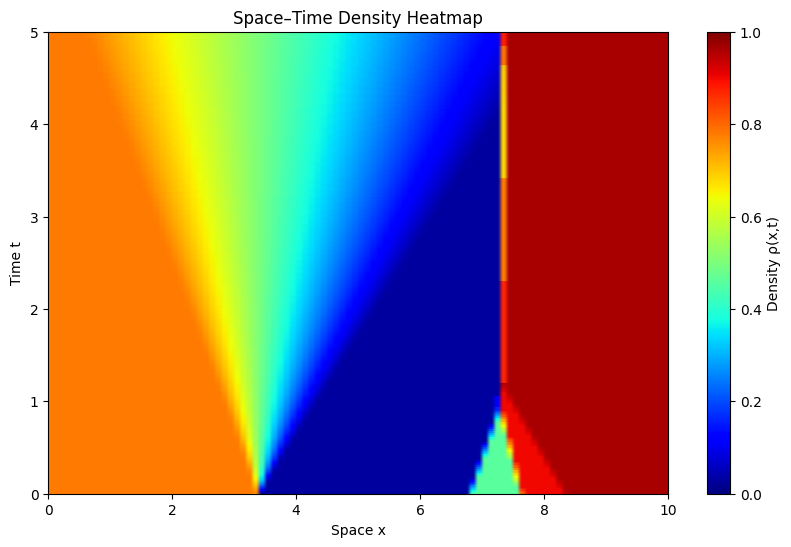

In [4]:
from operator_data_pipeline import get_nfv_dataset

from numerical_methods.plotter import plot_grid_density

nx = 100
nt = 500
dx = 0.1
dt = 0.01
grids = get_nfv_dataset(1, nx, nt, dx, dt, max_steps=5)
plot_grid_density(grids[0], nx, nt, dx, dt)
# animate_density(grids[0], nx, nt, dx, dt, output_name='test.gif')
# animate_density(grids[0].T, nt, nx, dt, dx, output_name='test1.gif',skip_frames=2)

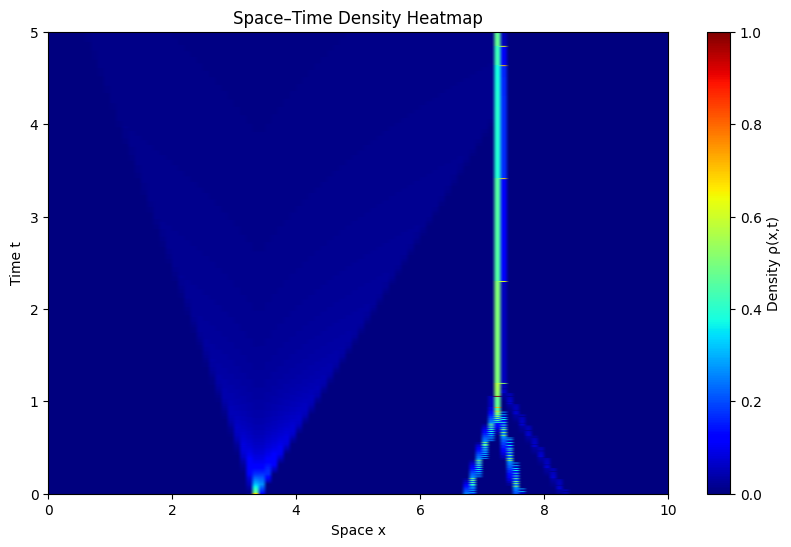

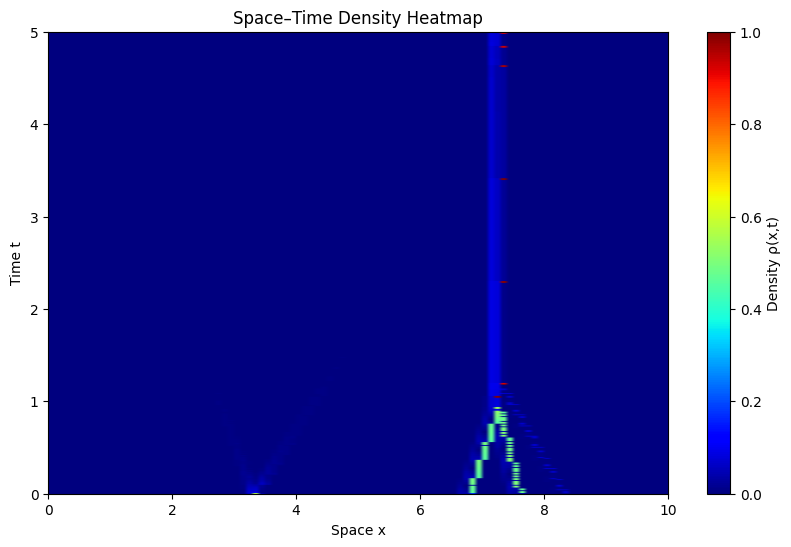

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


# Compute first order derivative using finite difference which sums the du/dt and du/dx
def first_order_derivative(grid):
    du_dt = np.abs((grid[1:] - grid[:-1]) / dt)
    du_dx = np.abs((grid[:, 1:] - grid[:, :-1]) / dx)

    # Make sure the grids are the same size
    du_dt = np.concatenate([du_dt, np.zeros((1, nx))], axis=0)
    du_dx = np.concatenate([du_dx, np.zeros((nt, 1))], axis=1)
    return du_dt + du_dx

# Compute second order derivative using finite difference which sums the du/dt and du/dx
def second_order_derivative(grid):
    du_dt = np.abs((grid[2:] - 2*grid[1:-1] + grid[:-2]) / dt**2)
    du_dx = np.abs((grid[:, 2:] - 2*grid[:, 1:-1] + grid[:, :-2]) / dx**2)

    # Make sure the grids are the same size
    du_dt = np.concatenate([du_dt, np.zeros((2, nx))], axis=0)
    du_dx = np.concatenate([du_dx, np.zeros((nt, 2))], axis=1)
    return du_dt + du_dx

# Compute first order derivative grid, and second order derivative grid
first_order_derivative_grid = first_order_derivative(grids[0])
second_order_derivative_grid = second_order_derivative(grids[0])

# Normalize the grids between 0 and 1
first_order_derivative_grid = (first_order_derivative_grid - first_order_derivative_grid.min()) / (first_order_derivative_grid.max() - first_order_derivative_grid.min())
second_order_derivative_grid = (second_order_derivative_grid - second_order_derivative_grid.min()) / (second_order_derivative_grid.max() - second_order_derivative_grid.min())

# Plot the grids
plot_grid_density(first_order_derivative_grid, nx, nt, dx, dt)
plot_grid_density(second_order_derivative_grid, nx, nt, dx, dt)
plt.show()


/workspace/saint-venant/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
3it [00:00,  9.07it/s]                       


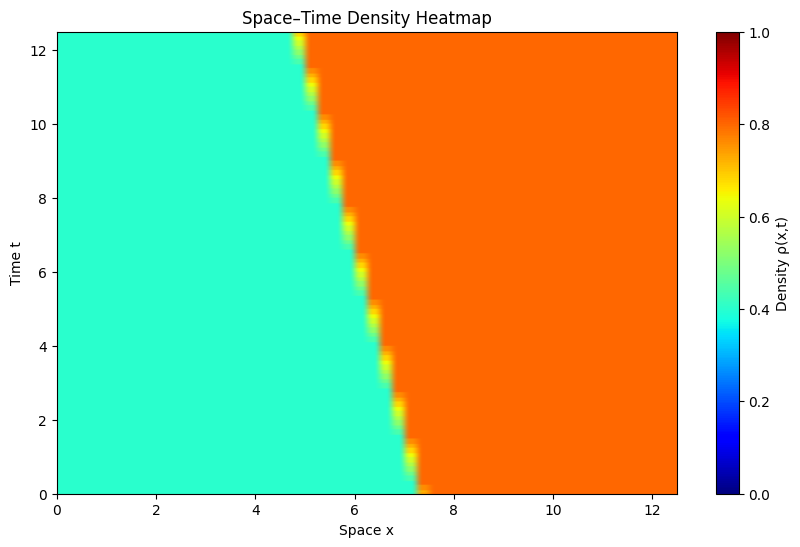

In [1]:
import torch
from nfv.flows import Greenshield
from nfv.problem import Problem
from nfv.solvers import LaxHopf
from operator_data_pipeline import PiecewiseRandom

from numerical_methods.plotter import plot_grid_density

nx = 50
nt = 250
dx = 0.25
dt = 0.05
max_steps = 3
ics = [PiecewiseRandom(ks=[0.4, 0.8], x_noise=False) for _ in range(10)]
problem = Problem(nx=nx, nt=nt, dx=dx, dt=dt, ic=ics, flow=Greenshield())
grids = problem.solve(LaxHopf, batch_size=4, dtype=torch.float64, progressbar=True).cpu().numpy()
plot_grid_density(grids[0], nx, nt, dx, dt)

In [30]:
import torch
from model import OperatorModel, WaveFrontFNO

model = OperatorModel(WaveFrontFNO,
            n_experts=5,
            n_modes=(16, 8),
            n_layers=4,
            hidden_dim=32,
            in_channels=3,
            num_encoder_layers=2,
            num_heads=4,
            max_fronts=5,
            boundary_sharpness=10.0,
        )

# Load state dict and filter out neuralop metadata key
state_dict = torch.load('operator.pth', weights_only=False)
state_dict = {k: v for k, v in state_dict.items() if k != '_metadata'}
model.load_state_dict(state_dict)


<All keys matched successfully>

torch.Size([4, 1, 250, 50])
torch.Size([4, 1, 250, 50])
torch.Size([2, 1, 250, 50])


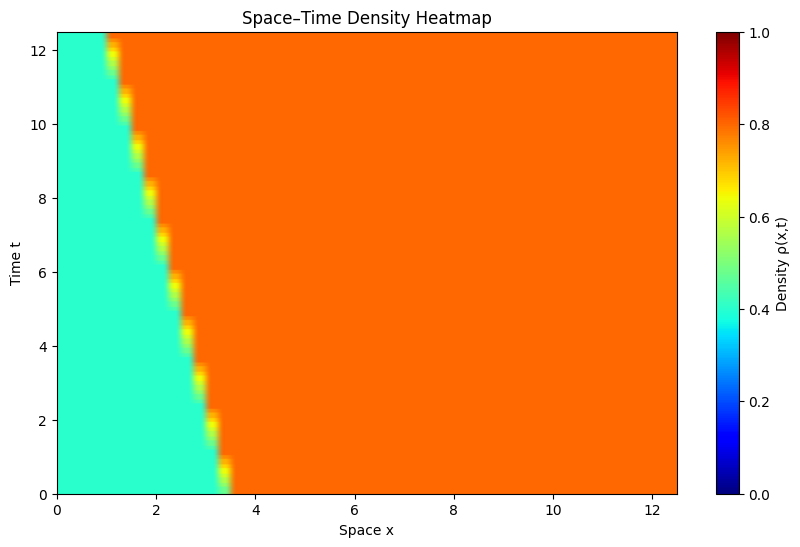

In [2]:
from operator_data_pipeline import GridDataset, preprocess_grids
from torch.utils.data import DataLoader

dataset = GridDataset(preprocess_grids(grids, nx, nt, dx, dt))
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

for input, target in dataloader:
    print(target.shape)
plot_grid_density(target[0].squeeze().detach().cpu().numpy(), nx, nt, dx, dt)


(tensor([0.4000, 0.8000]), tensor([14, 36]))


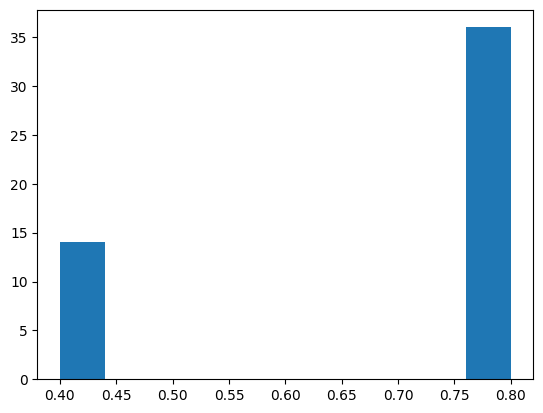

In [13]:
import matplotlib.pyplot as plt

# Flatten input[0, 0] and count occurrences of each unique element
print(input[0, 0, 0].unique(return_counts=True))
plt.hist(input[0, 0, 0].squeeze().detach().cpu().numpy().flatten())
plt.show()

Target:


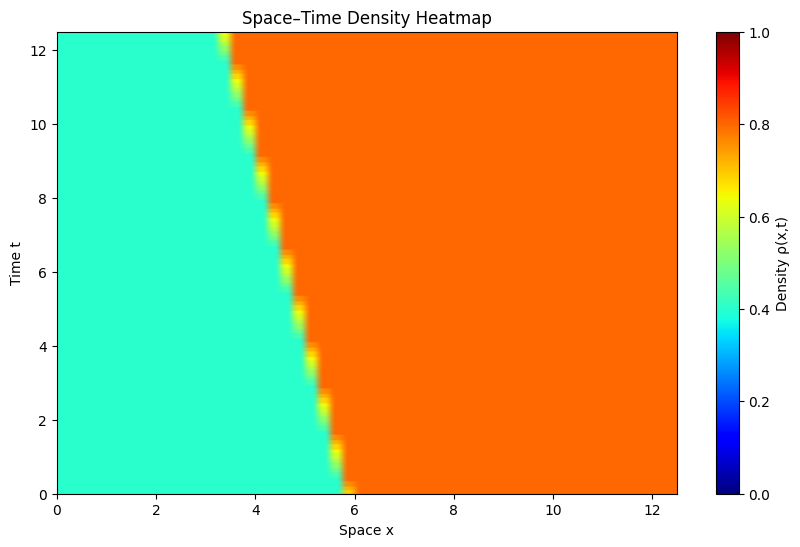

Prediction:


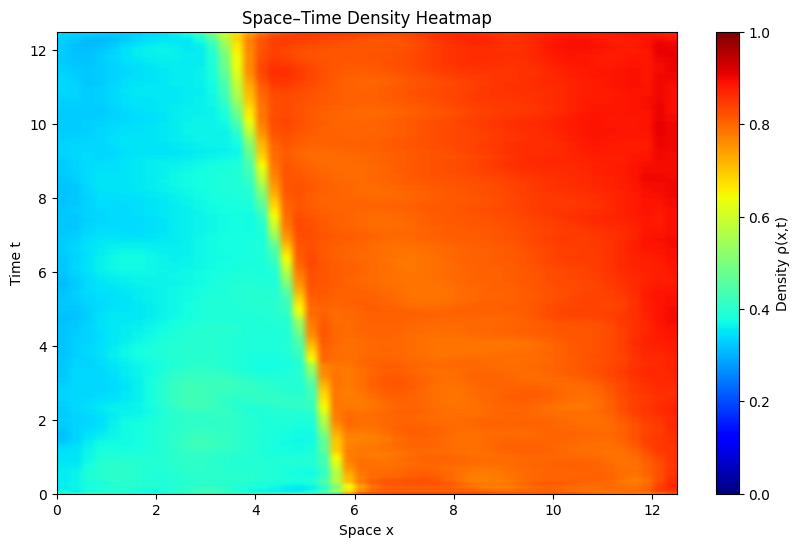

/tmp/ipykernel_168057/2118737918.py:48: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', n_experts)


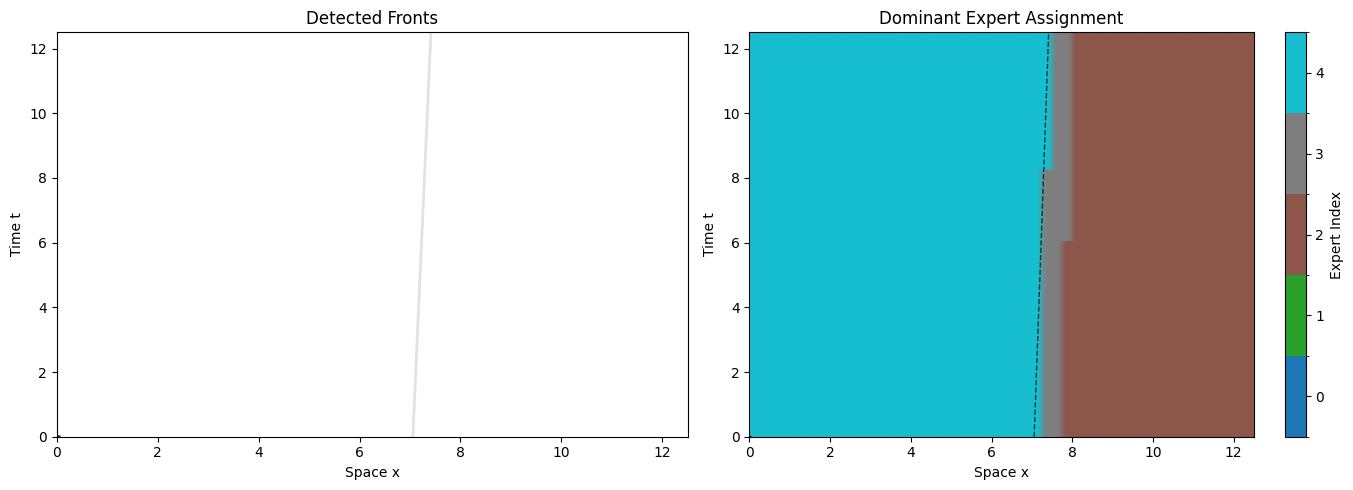

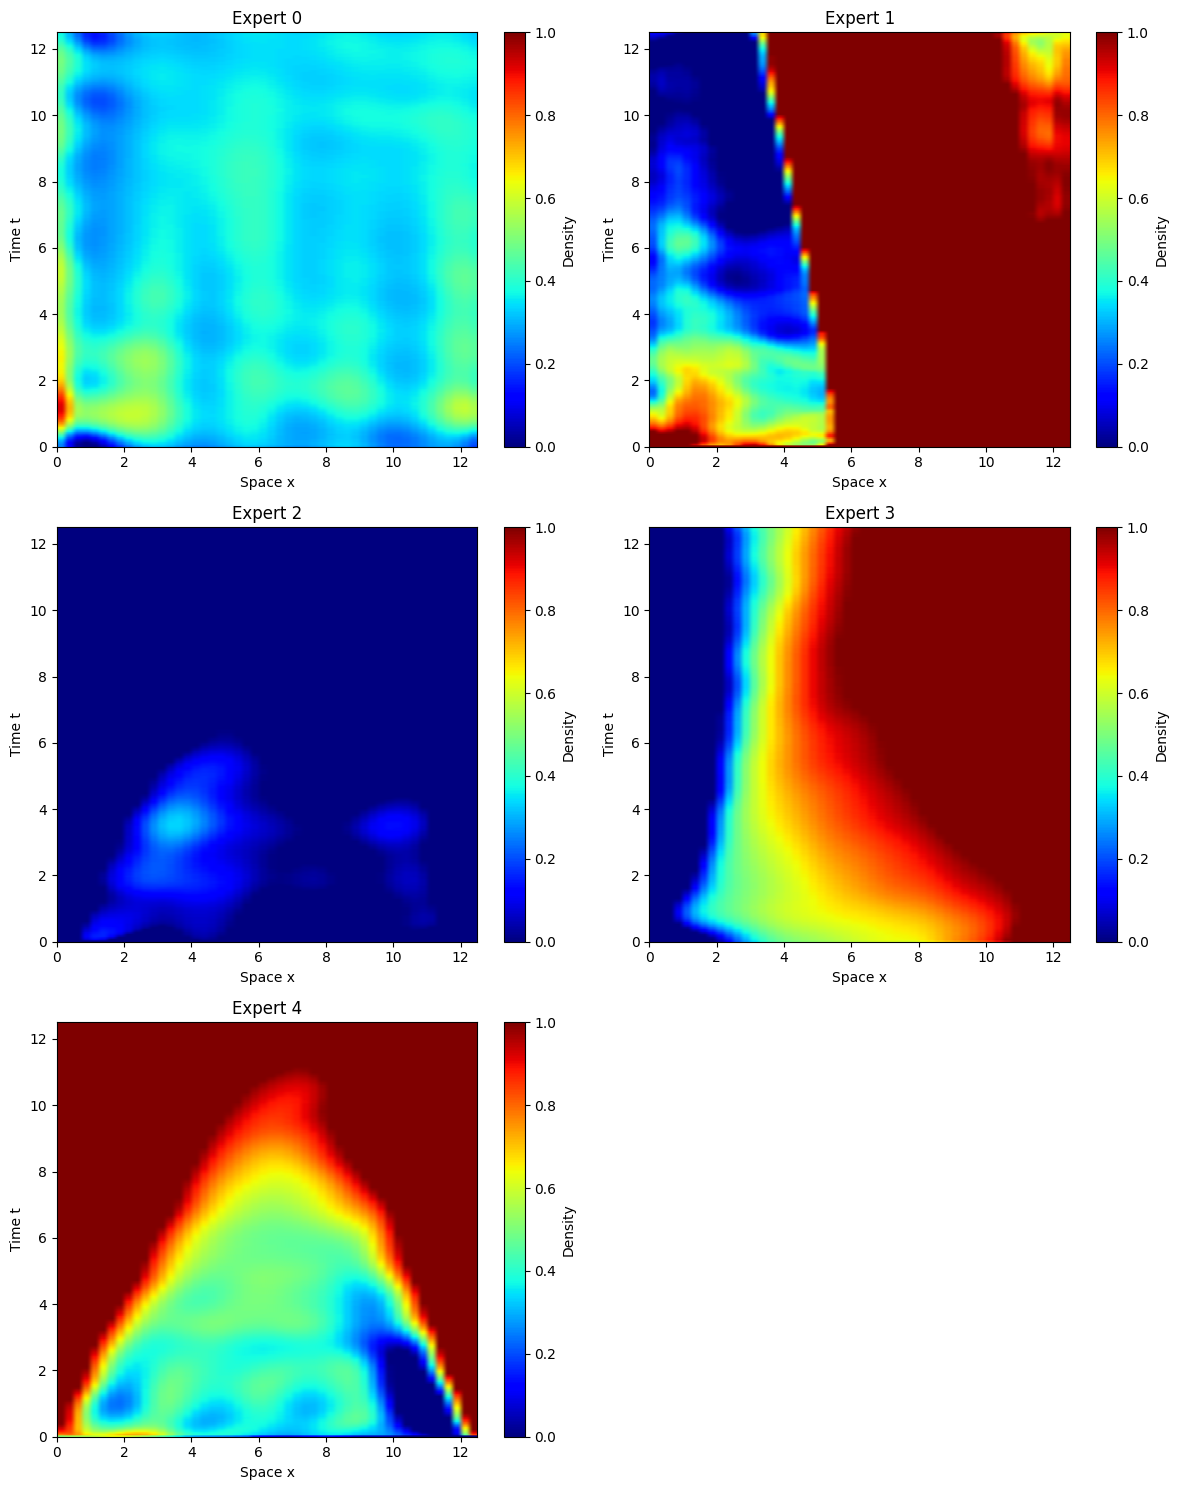

In [49]:
# Plot 4 grids: target, prediction, fronts, dominant expert
import matplotlib.pyplot as plt

# Get routing info from the model
with torch.no_grad():
    pred, routing_info = model.model(input, return_routing_info=True)

# Plot target and prediction using plot_grid_density
print("Target:")
plot_grid_density(target[0].squeeze().cpu().numpy(), nx, nt, dx, dt)
print("Prediction:")
plot_grid_density(pred[0].squeeze().cpu().numpy(), nx, nt, dx, dt)

# Extract front info
front_x0 = routing_info['front_x0'][0].cpu().numpy()  # (max_fronts,)
front_speed = routing_info['front_speed'][0].cpu().numpy()  # (max_fronts,)
front_strength = routing_info['front_strength'][0].cpu().numpy()  # (max_fronts,)
routing_weights = routing_info['routing_weights'][0].cpu().numpy()  # (T, X, n_experts)

T, X = routing_weights.shape[:2]
t_coords = np.linspace(0, nt * dt, T)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Detected fronts on white background
ax = axes[0]
ax.set_facecolor('white')
ax.set_xlabel('Space x')
ax.set_ylabel('Time t')
ax.set_title('Detected Fronts')

# Draw fronts as black lines: x(t) = x0 * nx * dx + speed * t
for i in range(len(front_x0)):
    if front_strength[i] > 0.1:  # Only plot significant fronts
        x_front = front_x0[i] * nx * dx + front_speed[i] * t_coords
        ax.plot(x_front, t_coords, 'k-', linewidth=2, alpha=front_strength[i])
ax.set_xlim(0, nx * dx)
ax.set_ylim(0, nt * dt)

# Plot 2: Dominant expert assignment
ax = axes[1]
dominant_expert = np.argmax(routing_weights, axis=-1)
n_experts = routing_weights.shape[-1]

# Use discrete colormap with exact number of experts
from matplotlib.colors import BoundaryNorm

cmap = plt.cm.get_cmap('tab10', n_experts)
bounds = np.arange(-0.5, n_experts, 1)
norm = BoundaryNorm(bounds, cmap.N)

im = ax.imshow(dominant_expert, aspect='auto', origin='lower',
               extent=[0, nx * dx, 0, nt * dt], cmap=cmap, norm=norm)
ax.set_xlabel('Space x')
ax.set_ylabel('Time t')
ax.set_title('Dominant Expert Assignment')
cbar = plt.colorbar(im, ax=ax, label='Expert Index', ticks=np.arange(n_experts))
cbar.ax.set_yticklabels([f'{i}' for i in range(n_experts)])

# Overlay fronts
for i in range(len(front_x0)):
    if front_strength[i] > 0.1:
        x_front = front_x0[i] * nx * dx + front_speed[i] * t_coords
        ax.plot(x_front, t_coords, 'k--', linewidth=1, alpha=0.7)
ax.set_xlim(0, nx * dx)
ax.set_ylim(0, nt * dt)

plt.tight_layout()
plt.show()

# Plot each expert's output in a grid with 2 columns
n_experts = model.model.n_experts
n_cols = 2
n_rows = (n_experts + n_cols - 1) // n_cols  # Ceiling division

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 5 * n_rows))
axes = axes.flatten()

with torch.no_grad():
    for i in range(n_experts):
        expert_out = model.model.experts[i](input)
        ax = axes[i]
        im = ax.imshow(expert_out[0].squeeze().cpu().numpy(), aspect='auto', origin='lower',
                       extent=[0, nx * dx, 0, nt * dt], cmap='jet', vmin=0, vmax=1)
        ax.set_xlabel('Space x')
        ax.set_ylabel('Time t')
        ax.set_title(f'Expert {i}')
        plt.colorbar(im, ax=ax, label='Density')

# Hide any unused subplots
for i in range(n_experts, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()